# Taurus

In [53]:
import aplpy
from astropy.io import fits
%pylab inline
#%matplotlib widget
#plt.style.use(['dark_background'])
path = '/user/workdir/albouyg/Gouldbelt/Taurus/'
name = 'taurus_L1495'

Populating the interactive namespace from numpy and matplotlib


## Read and prepare the map

In [54]:
figfile = path + 'HGBS_' + name + '_column_density_map.fits'

In [55]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

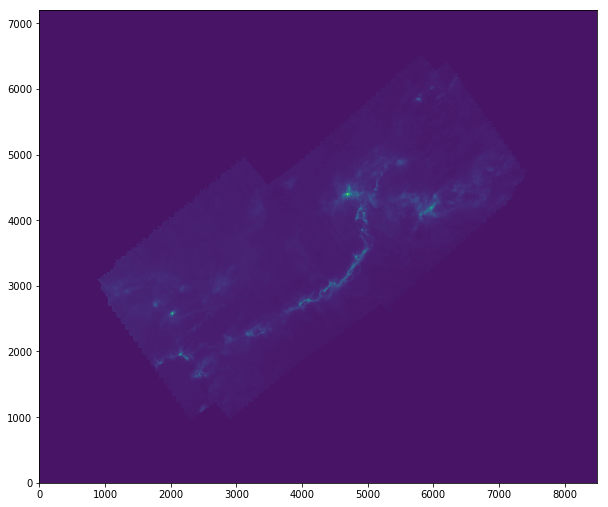

In [56]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

In [57]:
from pywavan import powspec, fan_trans, apodize, padding, subfits, gauss_beam

INFO: Auto-setting vmin to -5.000e+20 [aplpy.core]
INFO: Auto-setting vmax to  1.227e+22 [aplpy.core]


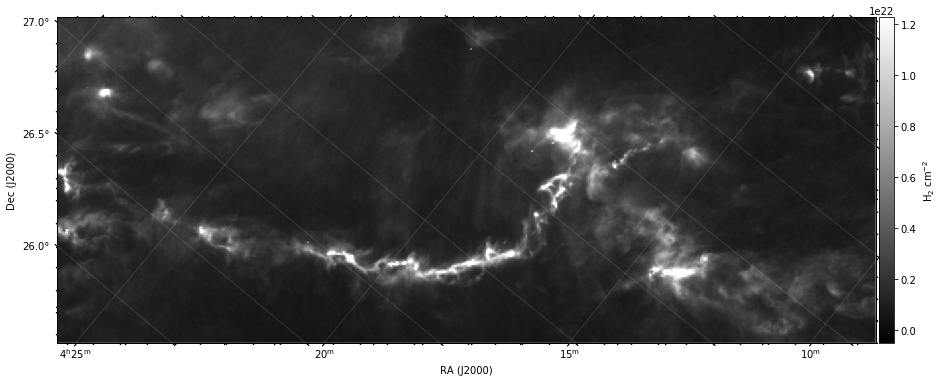

In [58]:
fig_all = plt.figure(1, figsize=(15,15))
fig = aplpy.FITSFigure(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cuts.fits',figure=fig_all)
fig.show_colorscale(cmap='gray')
#fig.tick_labels.set_xformat('hh')
fig.tick_labels.set_yformat('dd.d')
#fig.ticks.set_xspacing(15)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [67]:
#Read cut map
HDU = fits.open(path + 'HGBS_' + name + '_column_density_map_rebin_rot_cuts.fits')
im = HDU[0].data
header = HDU[0].header
print(im.shape)
print(im)

(491, 1236)
[[8.72813230e+20 8.31847080e+20 8.29076944e+20 ... 1.10753528e+21
  1.12331090e+21 1.06013433e+21]
 [8.38032704e+20 7.90226783e+20 8.63743402e+20 ... 1.13856586e+21
  1.03233959e+21 9.85838099e+20]
 [8.45775940e+20 9.34951997e+20 1.03219780e+21 ... 1.30235164e+21
  9.53243297e+20 9.12254137e+20]
 ...
 [2.28125265e+21 2.19950542e+21 2.22844879e+21 ... 6.62880396e+20
  7.12612098e+20 7.10613274e+20]
 [2.10035262e+21 2.11758776e+21 2.10062256e+21 ... 6.77595274e+20
  7.37774554e+20 6.74712126e+20]
 [2.14684033e+21 2.18320436e+21 2.07200964e+21 ... 6.53751248e+20
  5.98753993e+20 5.69399495e+20]]


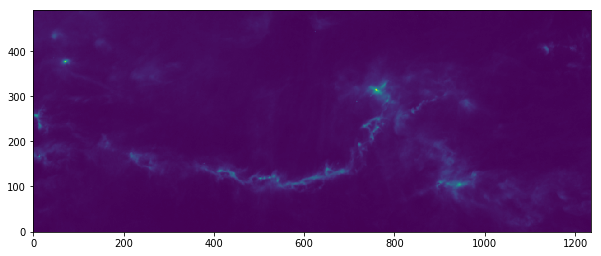

In [60]:
figure(figsize=(10,10))
imshow(im,origin='bottom')

In [78]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((600,1350))
#newdim = np.array((1300,1300))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#noise = S1a[0,20]

In [79]:
#Set a list of q
q=[]
q=[2.5]*30

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=False, apodize=.98)

1350 600


Text(0.5, 1.0, 'Beam power spectrum')

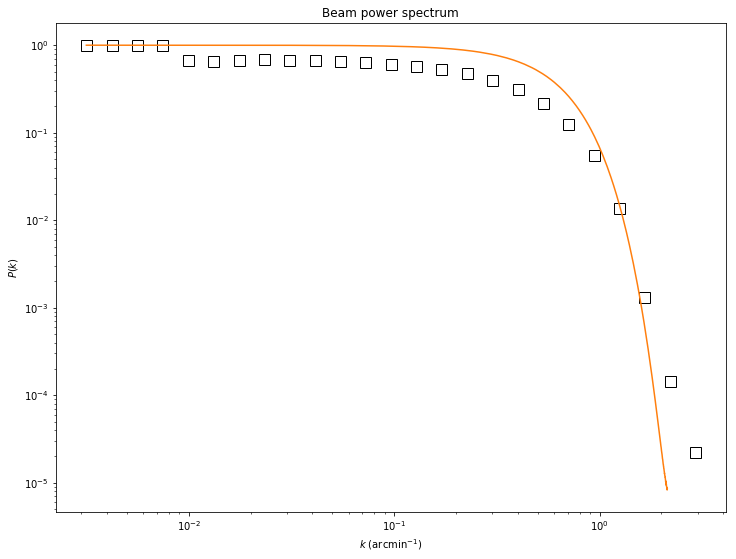

In [80]:
#Wavelet power spectrum of the telescope beam

beam = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data
beamr = padding(beam,newdim[0],newdim[1])

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, smooth=False)
del Bwt, BS11a, Bwav_k, Bq

tab_k, spec_beam2 = powspec(beamr,reso)
spec_beamn2 = spec_beam2 / spec_beam2[0]

#Spectrum normalisation
BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0

#Beam simulation
Sbeam = gauss_beam(36.9 / (60.*reso),newdim[0],newdim[1],FWHM=True)
tab_k, spec_beam = powspec(Sbeam,reso)
spec_beamn = spec_beam / spec_beam[0]

plt.figure(figsize(12,9))
plt.plot(wav_k, BS1an,'s', markersize = 11, markerfacecolor='none', markeredgecolor='black')
plt.plot(tab_k, spec_beamn)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.title('Beam power spectrum')

Power law fit
A, Gamma =  6.792398529661324e+41 -2.321235244808449
Uncertainties =  1.1050649682625115 0.04259402056157942


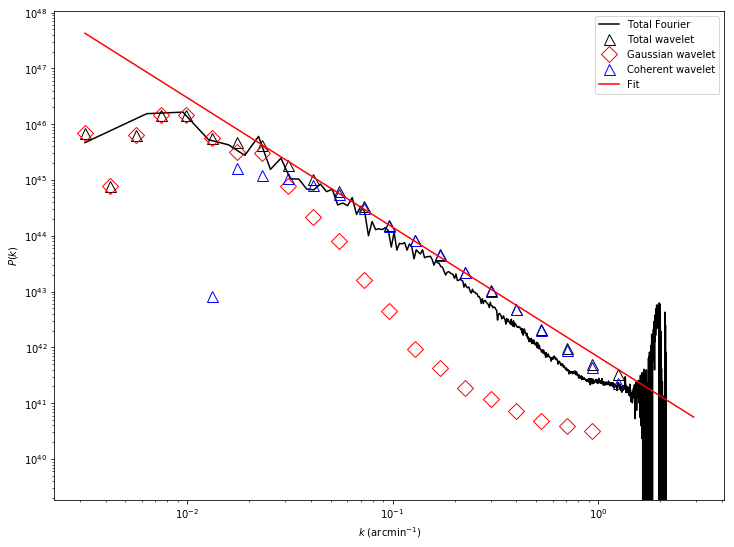

In [81]:
Noise = spec_k[-1]

#Power spectra fits
A, cov = np.polyfit(np.log(wav_k[8:18]), np.log(S1a[0,8:18]/BS1an[8:18]),deg=1,cov=True)
fit = np.exp(A[1])*wav_k**A[0]
print('Power law fit')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

plt.figure(figsize(12,9))
plt.plot(tab_k, (spec_k-Noise)/spec_beamn, color='black',label=r'Total Fourier')
plt.plot(wav_k, (S1a[0,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k, (S1a[2,:]-Noise)/BS1an,'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k, (S1a[1,:]-Noise)/BS1an,'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot(wav_k, fit, color='red',label=r'Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

[[[-inf -inf -inf ... -inf -inf -inf]
  [-inf -inf -inf ... -inf -inf -inf]
  [-inf -inf -inf ... -inf -inf -inf]
  ...
  [-inf -inf -inf ... -inf -inf -inf]
  [-inf -inf -inf ... -inf -inf -inf]
  [-inf -inf -inf ... -inf -inf -inf]]

 [[-inf -inf -inf ... -inf -inf -inf]
  [-inf -inf -inf ... -inf -inf -inf]
  [-inf -inf -inf ... -inf -inf -inf]
  ...
  [-inf -inf -inf ... -inf -inf -inf]
  [-inf -inf -inf ... -inf -inf -inf]
  [-inf -inf -inf ... -inf -inf -inf]]

 [[ inf  inf  inf ... -inf -inf -inf]
  [ inf  inf  inf ... -inf -inf -inf]
  [ inf  inf  inf ... -inf -inf -inf]
  ...
  [ inf  inf  inf ... -inf -inf -inf]
  [ inf  inf  inf ... -inf -inf -inf]
  [ inf  inf  inf ... -inf -inf -inf]]

 ...

 [[ inf  inf  inf ...  inf  inf  inf]
  [ inf -inf -inf ... -inf -inf  inf]
  [ inf -inf  inf ...  inf -inf  inf]
  ...
  [-inf -inf  inf ... -inf -inf  inf]
  [ inf -inf -inf ... -inf -inf  inf]
  [ inf  inf -inf ...  inf  inf -inf]]

 [[-inf  inf  inf ...  inf  inf -inf]
  [ inf -inf

Text(0.5, 1.0, 'Scale-free fractal simulation')

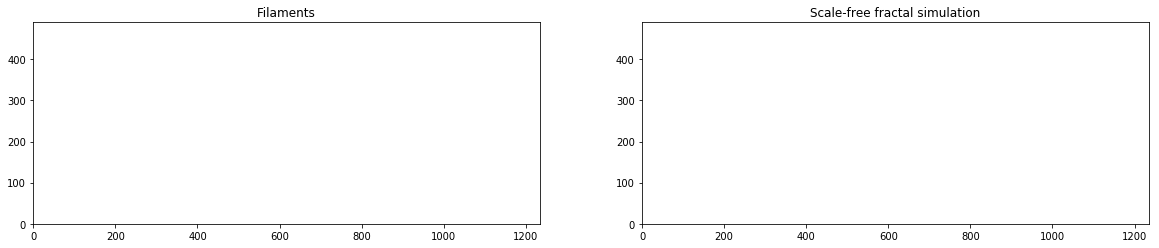

In [82]:
#Image reconstruction from the segmented wavelet coefficients
M=np.size(wav_k)
filaments = np.sum(wt[M:2*M,:,:].real,axis=0)
scale_free = np.sum(wt[2*M:3*M,:,:].real,axis=0)
print(wt.real)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_filaments.fits', filaments, overwrite=True)
fits.writeto(path + 'HGBS_' + name + '_column_density_map_reconst_scale_free.fits', scale_free, overwrite=True)

#Plot images
figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(filaments,origin='bottom')
plt.title('Filaments')

plt.subplot(1,2,2)
imshow(scale_free,origin='bottom')
plt.title('Scale-free fractal simulation')